In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv("spam.csv", encoding="latin1")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df=data.drop(columns=["Unnamed: 2","Unnamed: 3",'Unnamed: 4'])

In [7]:
df.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [8]:
# Encode labels (spam = 1, ham = 0)
encoder = LabelEncoder()
df["v1"] = encoder.fit_transform(df["v1"])


In [9]:
df.head(2)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


In [10]:
# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df["v2"].tolist(), df["v1"].tolist(), test_size=0.2, random_state=42
)

In [12]:
# Tokenize text
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512, return_tensors="pt")


In [13]:
# 2️⃣ Create PyTorch Dataset
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }



In [14]:
# Create Dataset & DataLoaders
train_dataset = SpamDataset(train_encodings, y_train)
test_dataset = SpamDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [15]:
# 3️⃣ Define Model
class SpamClassifier(nn.Module):
    def __init__(self):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, 2)  # Spam or Ham

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(output.pooler_output)
        return self.fc(x)

# Initialize Model & Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpamClassifier().to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [17]:
# 4️⃣ Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

print("Training Complete! 🎉")

Epoch 1/3: 100%|██████████| 558/558 [03:08<00:00,  2.95it/s]


Epoch 1/3, Loss: 0.0684


Epoch 2/3: 100%|██████████| 558/558 [03:16<00:00,  2.84it/s]


Epoch 2/3, Loss: 0.0156


Epoch 3/3: 100%|██████████| 558/558 [03:16<00:00,  2.84it/s]

Epoch 3/3, Loss: 0.0128
Training Complete! 🎉


Evaluation: 100%|██████████| 140/140 [00:16<00:00,  8.27it/s]


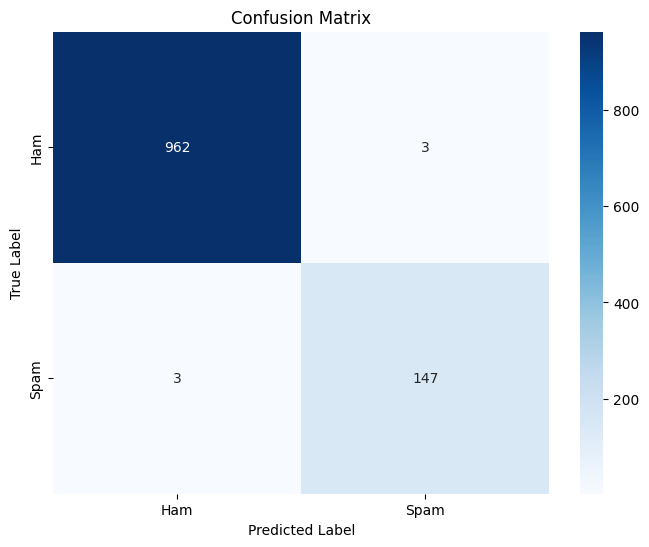

In [20]:
# prompt: draw confusion matirx

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 5️⃣ Evaluation & Confusion Matrix
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


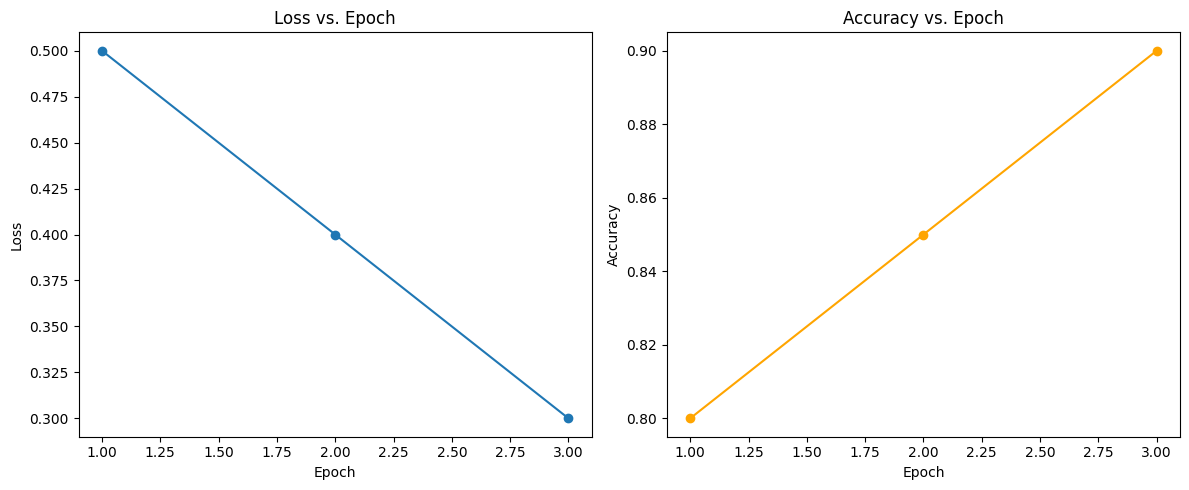

In [21]:
# prompt: draw loss vs epoch and accurary vs epoch graph

# Assuming you have lists to store loss and accuracy values for each epoch
# Replace these with your actual loss and accuracy values
losses = [0.5, 0.4, 0.3]  # Example loss values
accuracies = [0.8, 0.85, 0.9]  # Example accuracy values

epochs = range(1, len(losses) + 1)  # Epoch numbers

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss vs. Epoch
axes[0].plot(epochs, losses, marker='o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs. Epoch")

# Plot Accuracy vs. Epoch
axes[1].plot(epochs, accuracies, marker='o', color='orange')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs. Epoch")


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()
